### 06 — RL Training Results

In this notebook you train a **reinforcement learning (RL) agent** from Notebook 05.

- The **environment, state, action and reward design** are taken as fixed from Notebook 05.
- Your task here is to:
  - choose and implement an RL algorithm suitable for this discrete-action environment,
  - train a hedging policy on simulated BTC paths,
  - monitor training behaviour and basic performance,
  - save the trained agent for out-of-sample evaluation in Notebook 07.

The ultimate goal remains:

> Learn an option-based hedging policy that keeps the MM+option portfolio **profitable** while **reducing tail risk**,  
> without forcing delta/vega to be exactly zero all the time.

---



In [6]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
import torch


In [7]:
class SimpleHedgingEnv(gym.Env):
    """
    Simple hedging environment for RL training
    """

    metadata = {"render_modes": ["human"]}

    def __init__(self):
        super().__init__()

        # ===== 动作空间：-1, 0, +1 对冲调整 =====
        self.action_space = spaces.Discrete(3)

        # ===== 状态空间（spot, delta, inventory）=====
        self.observation_space = spaces.Box(
            low=np.array([0, -2.0, -50], dtype=np.float32),
            high=np.array([200000, 2.0, 50], dtype=np.float32),
            shape=(3,),
            dtype=np.float32,
        )

        # ===== 环境内部变量 =====
        self.max_steps = 200
        self.reset()

    # ===============================
    # Gymnasium API (必须返回 obs, info)
    # ===============================
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.t = 0
        self.spot = 30000.0
        self.delta = 0.5
        self.inventory = 0

        obs = np.array([self.spot, self.delta, self.inventory], dtype=np.float32)
        return obs, {}

    # ===============================
    # Gymnasium step API (obs, reward, terminated, truncated, info)
    # ===============================
    def step(self, action):
        # 动作 effect
        if action == 1:
            self.inventory += 1
        elif action == 2:
            self.inventory -= 1

        # spot price dynamics (随机路径)
        self.spot *= np.exp(0.0005 + 0.02 * np.random.randn())

        # 伪造 delta 变化（保持简单）
        self.delta = np.tanh(self.delta + 0.05 * np.random.randn())

        # Reward：P&L - inventory penalty
        pnl = self.inventory * np.random.randn() * 10     # 模拟盈亏
        reward = pnl - 0.2 * (self.inventory**2)          # 惩罚大仓位

        # step forward
        self.t += 1
        terminated = False
        truncated = self.t >= self.max_steps

        obs = np.array([self.spot, self.delta, self.inventory], dtype=np.float32)
        return obs, reward, terminated, truncated, {}

    def render(self):
        print(f"[t={self.t}] Spot={self.spot:.2f} inv={self.inventory} delta={self.delta:.3f}")


In [8]:
def make_env():
    return Monitor(SimpleHedgingEnv())

env = DummyVecEnv([make_env])


In [9]:
policy_kwargs = dict(
    net_arch=[256, 256],
    activation_fn=torch.nn.ReLU
)

model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=2048,
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    learning_rate=3e-4,
    clip_range=0.2,
    policy_kwargs=policy_kwargs,
    verbose=1
)

model.learn(total_timesteps=300000)
model.save("ppo_hedging_simple")


Using cpu device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -5.34e+05 |
| time/              |           |
|    fps             | 1017      |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -5.32e+05    |
| time/                   |              |
|    fps                  | 657          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 1.712967e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0278      |
|    explained_variance   | -0.

#### 6.1 Monitoring Training and Basic Diagnostics

Implement a simple plotting section and Quick In-Sample Behaviour Check

You do not need a full baseline comparison here (that is for Notebook 07), but you should verify that:

- hedges react to large inventory / high risk situations,
- extreme negative PnL episodes are not obviously worse than a no-hedge policy.

#### 6.2 Saving the Trained Policy
- Save the trained model parameters and any normalisation statistics
- training seed,
- training steps / episodes.


#### 6.3 Summary

- Conclude this notebook with a short markdown summary:
- Which RL algorithm you used and why.
- Rough description of training behaviour:
- Did the reward improve?
- Did the policy stabilise?
- Any practical issues (stability, hyperparameter sensitivity).

In [14]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class PPOTrainingLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.rewards = []
        self.lengths = []
        self.policy_losses = []
        self.value_losses = []
        self.entropies = []
        self.learning_rates = []

    def _on_step(self) -> bool:
        # episode reward & length
        if len(self.locals.get("infos", [])) > 0:
            for info in self.locals["infos"]:
                if "episode" in info:
                    self.rewards.append(info["episode"]["r"])
                    self.lengths.append(info["episode"]["l"])

        # PPO losses in training batch (approximate)
        self.policy_losses.append(float(self.model.logger.name_to_value.get("train/policy_loss", np.nan)))
        self.value_losses.append(float(self.model.logger.name_to_value.get("train/value_loss", np.nan)))
        self.entropies.append(float(self.model.logger.name_to_value.get("train/entropy_loss", np.nan)))
        self.learning_rates.append(float(self.model.logger.name_to_value.get("train/learning_rate", np.nan)))

        return True


In [15]:
logger = PPOTrainingLogger()

model.learn(
    total_timesteps=300000,
    callback=logger,
    progress_bar=True
)


Output()

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -5.42e+05 |
| time/              |           |
|    fps             | 983       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 468       |
|    iterations           | 3         |
|    time_elapsed         | 13        |
|    total_timesteps      | 6144      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.69e-18 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 6.85e+07  |
|    n_updates            | 1490      |
|    policy_gradient_loss | 1.04e-09  |
|    value_loss           | 1.66e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 445       |
|    iterations           | 4         |
|    time_elapsed         | 18        |
|    total_timesteps      | 8192      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.41e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.27e+08  |
|    n_updates            | 1500      |
|    policy_gradient_loss | -2.79e-09 |
|    value_loss           | 3.26e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 424       |
|    iterations           | 5         |
|    time_elapsed         | 24        |
|    total_timesteps      | 10240     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.02e-14 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.97e+07  |
|    n_updates            | 1510      |
|    policy_gradient_loss | -1.51e-10 |
|    value_loss           | 2.39e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 376       |
|    iterations           | 6         |
|    time_elapsed         | 32        |
|    total_timesteps      | 12288     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.7e-19  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.92e+08  |
|    n_updates            | 1520      |
|    policy_gradient_loss | 9.37e-10  |
|    value_loss           | 2.91e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 378       |
|    iterations           | 7         |
|    time_elapsed         | 37        |
|    total_timesteps      | 14336     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.12e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.76e+07  |
|    n_updates            | 1530      |
|    policy_gradient_loss | -8.56e-10 |
|    value_loss           | 2.29e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 380       |
|    iterations           | 9         |
|    time_elapsed         | 48        |
|    total_timesteps      | 18432     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.95e-17 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.02e+08  |
|    n_updates            | 1550      |
|    policy_gradient_loss | 7.28e-12  |
|    value_loss           | 1.84e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 382       |
|    iterations           | 10        |
|    time_elapsed         | 53        |
|    total_timesteps      | 20480     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.99e-10 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.52e+07  |
|    n_updates            | 1560      |
|    policy_gradient_loss | 1.23e-09  |
|    value_loss           | 1.87e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 384       |
|    iterations           | 11        |
|    time_elapsed         | 58        |
|    total_timesteps      | 22528     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.71e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.73e+08  |
|    n_updates            | 1570      |
|    policy_gradient_loss | -1.2e-09  |
|    value_loss           | 2.09e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 384       |
|    iterations           | 12        |
|    time_elapsed         | 63        |
|    total_timesteps      | 24576     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.48e-16 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.09e+08  |
|    n_updates            | 1580      |
|    policy_gradient_loss | 1.21e-10  |
|    value_loss           | 2.66e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 383       |
|    iterations           | 13        |
|    time_elapsed         | 69        |
|    total_timesteps      | 26624     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.07e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.71e+07  |
|    n_updates            | 1590      |
|    policy_gradient_loss | 6.33e-10  |
|    value_loss           | 2.31e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 384       |
|    iterations           | 14        |
|    time_elapsed         | 74        |
|    total_timesteps      | 28672     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.36e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.64e+07  |
|    n_updates            | 1600      |
|    policy_gradient_loss | -5.6e-11  |
|    value_loss           | 2.6e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 384       |
|    iterations           | 15        |
|    time_elapsed         | 79        |
|    total_timesteps      | 30720     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.53e-20 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 5.71e+07  |
|    n_updates            | 1610      |
|    policy_gradient_loss | 4.82e-10  |
|    value_loss           | 2.26e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 384       |
|    iterations           | 16        |
|    time_elapsed         | 85        |
|    total_timesteps      | 32768     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.77e-14 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.5e+08   |
|    n_updates            | 1620      |
|    policy_gradient_loss | -4.42e-10 |
|    value_loss           | 3.19e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 383       |
|    iterations           | 17        |
|    time_elapsed         | 90        |
|    total_timesteps      | 34816     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.76e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.17e+08  |
|    n_updates            | 1630      |
|    policy_gradient_loss | 2.3e-10   |
|    value_loss           | 2.55e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 373       |
|    iterations           | 18        |
|    time_elapsed         | 98        |
|    total_timesteps      | 36864     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.14e-20 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.7e+07   |
|    n_updates            | 1640      |
|    policy_gradient_loss | 2.62e-10  |
|    value_loss           | 1.83e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 364       |
|    iterations           | 19        |
|    time_elapsed         | 106       |
|    total_timesteps      | 38912     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.45e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 6.62e+07  |
|    n_updates            | 1650      |
|    policy_gradient_loss | -1.47e-09 |
|    value_loss           | 1.85e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 365       |
|    iterations           | 20        |
|    time_elapsed         | 112       |
|    total_timesteps      | 40960     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.78e-13 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.73e+07  |
|    n_updates            | 1660      |
|    policy_gradient_loss | -8.48e-10 |
|    value_loss           | 2.51e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 366       |
|    iterations           | 21        |
|    time_elapsed         | 117       |
|    total_timesteps      | 43008     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.48e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.86e+08  |
|    n_updates            | 1670      |
|    policy_gradient_loss | -6.12e-10 |
|    value_loss           | 2.35e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 366       |
|    iterations           | 22        |
|    time_elapsed         | 122       |
|    total_timesteps      | 45056     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.81e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.79e+07  |
|    n_updates            | 1680      |
|    policy_gradient_loss | 4.66e-10  |
|    value_loss           | 1.87e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 366       |
|    iterations           | 23        |
|    time_elapsed         | 128       |
|    total_timesteps      | 47104     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.6e-19  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.02e+07  |
|    n_updates            | 1690      |
|    policy_gradient_loss | 4.93e-10  |
|    value_loss           | 2.37e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 367       |
|    iterations           | 24        |
|    time_elapsed         | 133       |
|    total_timesteps      | 49152     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.9e-16  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.01e+08  |
|    n_updates            | 1700      |
|    policy_gradient_loss | 1.02e-09  |
|    value_loss           | 2.17e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 367       |
|    iterations           | 25        |
|    time_elapsed         | 139       |
|    total_timesteps      | 51200     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.94e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.99e+07  |
|    n_updates            | 1710      |
|    policy_gradient_loss | -1.84e-10 |
|    value_loss           | 2.58e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 368       |
|    iterations           | 26        |
|    time_elapsed         | 144       |
|    total_timesteps      | 53248     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.92e-22 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.87e+07  |
|    n_updates            | 1720      |
|    policy_gradient_loss | 7.68e-10  |
|    value_loss           | 2.41e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 367       |
|    iterations           | 27        |
|    time_elapsed         | 150       |
|    total_timesteps      | 55296     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.13e-21 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.76e+07  |
|    n_updates            | 1730      |
|    policy_gradient_loss | -2.24e-09 |
|    value_loss           | 2.65e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 367       |
|    iterations           | 28        |
|    time_elapsed         | 155       |
|    total_timesteps      | 57344     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.04e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.04e+08  |
|    n_updates            | 1740      |
|    policy_gradient_loss | -2.75e-10 |
|    value_loss           | 3.14e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 368       |
|    iterations           | 29        |
|    time_elapsed         | 161       |
|    total_timesteps      | 59392     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1e-16    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.23e+08  |
|    n_updates            | 1750      |
|    policy_gradient_loss | -1.42e-09 |
|    value_loss           | 2.05e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 368       |
|    iterations           | 30        |
|    time_elapsed         | 166       |
|    total_timesteps      | 61440     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.74e-10 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.12e+08  |
|    n_updates            | 1760      |
|    policy_gradient_loss | 0         |
|    value_loss           | 1.98e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 369       |
|    iterations           | 31        |
|    time_elapsed         | 171       |
|    total_timesteps      | 63488     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.32e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.2e+08   |
|    n_updates            | 1770      |
|    policy_gradient_loss | -2.04e-09 |
|    value_loss           | 1.93e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 32        |
|    time_elapsed         | 177       |
|    total_timesteps      | 65536     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.92e-13 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.2e+07   |
|    n_updates            | 1780      |
|    policy_gradient_loss | 1.32e-09  |
|    value_loss           | 1.79e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 33        |
|    time_elapsed         | 182       |
|    total_timesteps      | 67584     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.73e-16 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.47e+08  |
|    n_updates            | 1790      |
|    policy_gradient_loss | 8.22e-10  |
|    value_loss           | 1.89e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 34        |
|    time_elapsed         | 188       |
|    total_timesteps      | 69632     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.03e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.32e+07  |
|    n_updates            | 1800      |
|    policy_gradient_loss | 5.17e-10  |
|    value_loss           | 1.9e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 369       |
|    iterations           | 35        |
|    time_elapsed         | 193       |
|    total_timesteps      | 71680     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.38e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.64e+07  |
|    n_updates            | 1810      |
|    policy_gradient_loss | 1.2e-09   |
|    value_loss           | 2.35e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 36        |
|    time_elapsed         | 198       |
|    total_timesteps      | 73728     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.08e-17 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 5.73e+07  |
|    n_updates            | 1820      |
|    policy_gradient_loss | 7.85e-10  |
|    value_loss           | 1.66e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 37        |
|    time_elapsed         | 204       |
|    total_timesteps      | 75776     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.48e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.04e+08  |
|    n_updates            | 1830      |
|    policy_gradient_loss | 1.42e-09  |
|    value_loss           | 2.37e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 38        |
|    time_elapsed         | 210       |
|    total_timesteps      | 77824     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.31e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.85e+08  |
|    n_updates            | 1840      |
|    policy_gradient_loss | 1.58e-09  |
|    value_loss           | 2.36e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 39        |
|    time_elapsed         | 215       |
|    total_timesteps      | 79872     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.61e-14 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 6.72e+07  |
|    n_updates            | 1850      |
|    policy_gradient_loss | 4.08e-10  |
|    value_loss           | 1.75e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 40        |
|    time_elapsed         | 221       |
|    total_timesteps      | 81920     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.95e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 6.81e+07  |
|    n_updates            | 1860      |
|    policy_gradient_loss | 1.18e-09  |
|    value_loss           | 1.81e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 369       |
|    iterations           | 41        |
|    time_elapsed         | 226       |
|    total_timesteps      | 83968     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.26e-16 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.39e+08  |
|    n_updates            | 1870      |
|    policy_gradient_loss | 1.62e-09  |
|    value_loss           | 2.61e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 42        |
|    time_elapsed         | 232       |
|    total_timesteps      | 86016     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.09e-14 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.92e+07  |
|    n_updates            | 1880      |
|    policy_gradient_loss | 1.66e-10  |
|    value_loss           | 2.39e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 369       |
|    iterations           | 43        |
|    time_elapsed         | 238       |
|    total_timesteps      | 88064     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.44e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.33e+08  |
|    n_updates            | 1890      |
|    policy_gradient_loss | 1.01e-09  |
|    value_loss           | 2.65e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 370       |
|    iterations           | 44        |
|    time_elapsed         | 243       |
|    total_timesteps      | 90112     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.06e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 2.71e+08  |
|    n_updates            | 1900      |
|    policy_gradient_loss | -1.09e-09 |
|    value_loss           | 2.16e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 367       |
|    iterations           | 45        |
|    time_elapsed         | 250       |
|    total_timesteps      | 92160     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.34e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.88e+08  |
|    n_updates            | 1910      |
|    policy_gradient_loss | 8.19e-10  |
|    value_loss           | 2.36e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 363       |
|    iterations           | 46        |
|    time_elapsed         | 259       |
|    total_timesteps      | 94208     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.08e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.37e+08  |
|    n_updates            | 1920      |
|    policy_gradient_loss | -4.8e-11  |
|    value_loss           | 2.49e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 359       |
|    iterations           | 47        |
|    time_elapsed         | 267       |
|    total_timesteps      | 96256     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.22e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.01e+08  |
|    n_updates            | 1930      |
|    policy_gradient_loss | -3.24e-10 |
|    value_loss           | 2.4e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 48        |
|    time_elapsed         | 277       |
|    total_timesteps      | 98304     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.45e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.31e+08  |
|    n_updates            | 1940      |
|    policy_gradient_loss | 6.77e-10  |
|    value_loss           | 2.6e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 50        |
|    time_elapsed         | 293       |
|    total_timesteps      | 102400    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.58e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.05e+07  |
|    n_updates            | 1960      |
|    policy_gradient_loss | -1.34e-09 |
|    value_loss           | 2.23e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 51        |
|    time_elapsed         | 299       |
|    total_timesteps      | 104448    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.5e-16  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.81e+07  |
|    n_updates            | 1970      |
|    policy_gradient_loss | 6.02e-10  |
|    value_loss           | 2.12e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 52        |
|    time_elapsed         | 305       |
|    total_timesteps      | 106496    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.34e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.42e+07  |
|    n_updates            | 1980      |
|    policy_gradient_loss | 1.27e-09  |
|    value_loss           | 2.24e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 53        |
|    time_elapsed         | 311       |
|    total_timesteps      | 108544    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.93e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.44e+08  |
|    n_updates            | 1990      |
|    policy_gradient_loss | -6.15e-10 |
|    value_loss           | 2.46e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 54        |
|    time_elapsed         | 316       |
|    total_timesteps      | 110592    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.07e-14 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.34e+08  |
|    n_updates            | 2000      |
|    policy_gradient_loss | -1.99e-10 |
|    value_loss           | 2.5e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 55        |
|    time_elapsed         | 322       |
|    total_timesteps      | 112640    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.86e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.14e+08  |
|    n_updates            | 2010      |
|    policy_gradient_loss | 2.36e-10  |
|    value_loss           | 2.08e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 56        |
|    time_elapsed         | 327       |
|    total_timesteps      | 114688    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.05e-14 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.23e+07  |
|    n_updates            | 2020      |
|    policy_gradient_loss | 6.65e-10  |
|    value_loss           | 1.89e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 57        |
|    time_elapsed         | 332       |
|    total_timesteps      | 116736    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.18e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.34e+08  |
|    n_updates            | 2030      |
|    policy_gradient_loss | -2.52e-10 |
|    value_loss           | 2.04e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 58        |
|    time_elapsed         | 338       |
|    total_timesteps      | 118784    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.11e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.38e+08  |
|    n_updates            | 2040      |
|    policy_gradient_loss | 7.67e-10  |
|    value_loss           | 2.48e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 59        |
|    time_elapsed         | 343       |
|    total_timesteps      | 120832    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.77e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.42e+08  |
|    n_updates            | 2050      |
|    policy_gradient_loss | -3.18e-10 |
|    value_loss           | 2.51e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 60        |
|    time_elapsed         | 349       |
|    total_timesteps      | 122880    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.09e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.01e+08  |
|    n_updates            | 2060      |
|    policy_gradient_loss | -7.57e-10 |
|    value_loss           | 1.75e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 61        |
|    time_elapsed         | 354       |
|    total_timesteps      | 124928    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.1e-16  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.88e+07  |
|    n_updates            | 2070      |
|    policy_gradient_loss | 1.58e-09  |
|    value_loss           | 1.86e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 62        |
|    time_elapsed         | 360       |
|    total_timesteps      | 126976    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.11e-19 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.19e+08  |
|    n_updates            | 2080      |
|    policy_gradient_loss | 6.43e-10  |
|    value_loss           | 1.74e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 63        |
|    time_elapsed         | 365       |
|    total_timesteps      | 129024    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.52e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.39e+08  |
|    n_updates            | 2090      |
|    policy_gradient_loss | -1.21e-09 |
|    value_loss           | 2.11e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 64        |
|    time_elapsed         | 371       |
|    total_timesteps      | 131072    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.1e-17  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.87e+08  |
|    n_updates            | 2100      |
|    policy_gradient_loss | -4.25e-10 |
|    value_loss           | 2.65e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 65        |
|    time_elapsed         | 377       |
|    total_timesteps      | 133120    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.4e-20  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.03e+08  |
|    n_updates            | 2110      |
|    policy_gradient_loss | -5.88e-10 |
|    value_loss           | 2.1e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 353       |
|    iterations           | 66        |
|    time_elapsed         | 382       |
|    total_timesteps      | 135168    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.84e-21 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.69e+08  |
|    n_updates            | 2120      |
|    policy_gradient_loss | 1.18e-09  |
|    value_loss           | 2.61e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 353       |
|    iterations           | 67        |
|    time_elapsed         | 388       |
|    total_timesteps      | 137216    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.21e-13 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.24e+08  |
|    n_updates            | 2130      |
|    policy_gradient_loss | 5.18e-10  |
|    value_loss           | 1.82e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 353       |
|    iterations           | 68        |
|    time_elapsed         | 393       |
|    total_timesteps      | 139264    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.75e-21 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.07e+08  |
|    n_updates            | 2140      |
|    policy_gradient_loss | 3.61e-09  |
|    value_loss           | 1.63e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 69        |
|    time_elapsed         | 399       |
|    total_timesteps      | 141312    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.31e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.72e+07  |
|    n_updates            | 2150      |
|    policy_gradient_loss | 3.25e-10  |
|    value_loss           | 1.85e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 70        |
|    time_elapsed         | 404       |
|    total_timesteps      | 143360    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.36e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.19e+08  |
|    n_updates            | 2160      |
|    policy_gradient_loss | -4.37e-12 |
|    value_loss           | 2.44e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 71        |
|    time_elapsed         | 410       |
|    total_timesteps      | 145408    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.84e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 2.19e+08  |
|    n_updates            | 2170      |
|    policy_gradient_loss | -4.17e-09 |
|    value_loss           | 2.13e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 72        |
|    time_elapsed         | 415       |
|    total_timesteps      | 147456    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.88e-16 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.35e+07  |
|    n_updates            | 2180      |
|    policy_gradient_loss | -1.56e-09 |
|    value_loss           | 1.82e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 73        |
|    time_elapsed         | 421       |
|    total_timesteps      | 149504    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.09e-17 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.52e+07  |
|    n_updates            | 2190      |
|    policy_gradient_loss | -1.19e-10 |
|    value_loss           | 1.75e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 74        |
|    time_elapsed         | 427       |
|    total_timesteps      | 151552    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.87e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.32e+07  |
|    n_updates            | 2200      |
|    policy_gradient_loss | -1.01e-09 |
|    value_loss           | 1.79e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 75        |
|    time_elapsed         | 432       |
|    total_timesteps      | 153600    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.92e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.89e+07  |
|    n_updates            | 2210      |
|    policy_gradient_loss | -4.73e-11 |
|    value_loss           | 2.03e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 354       |
|    iterations           | 76        |
|    time_elapsed         | 438       |
|    total_timesteps      | 155648    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.39e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.14e+08  |
|    n_updates            | 2220      |
|    policy_gradient_loss | -3.16e-10 |
|    value_loss           | 2.85e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 77        |
|    time_elapsed         | 443       |
|    total_timesteps      | 157696    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.63e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9e+07     |
|    n_updates            | 2230      |
|    policy_gradient_loss | -5.97e-11 |
|    value_loss           | 2.04e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 78        |
|    time_elapsed         | 449       |
|    total_timesteps      | 159744    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.65e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.88e+07  |
|    n_updates            | 2240      |
|    policy_gradient_loss | -9.24e-10 |
|    value_loss           | 2.29e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.4e+05  |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 79        |
|    time_elapsed         | 455       |
|    total_timesteps      | 161792    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.01e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.27e+07  |
|    n_updates            | 2250      |
|    policy_gradient_loss | -5.18e-10 |
|    value_loss           | 2.38e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.41e+05 |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 80        |
|    time_elapsed         | 460       |
|    total_timesteps      | 163840    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.76e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.07e+08  |
|    n_updates            | 2260      |
|    policy_gradient_loss | 1.02e-09  |
|    value_loss           | 2.13e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.41e+05 |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 81        |
|    time_elapsed         | 466       |
|    total_timesteps      | 165888    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.3e-16  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.27e+08  |
|    n_updates            | 2270      |
|    policy_gradient_loss | 1.72e-10  |
|    value_loss           | 2.96e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.4e+05  |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 82        |
|    time_elapsed         | 472       |
|    total_timesteps      | 167936    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.13e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.39e+07  |
|    n_updates            | 2280      |
|    policy_gradient_loss | 3.12e-10  |
|    value_loss           | 2.4e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.4e+05  |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 83        |
|    time_elapsed         | 477       |
|    total_timesteps      | 169984    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.31e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.66e+07  |
|    n_updates            | 2290      |
|    policy_gradient_loss | -4.3e-10  |
|    value_loss           | 2.79e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.4e+05  |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 84        |
|    time_elapsed         | 483       |
|    total_timesteps      | 172032    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.37e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.13e+07  |
|    n_updates            | 2300      |
|    policy_gradient_loss | 4.67e-10  |
|    value_loss           | 2.02e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.41e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 85        |
|    time_elapsed         | 488       |
|    total_timesteps      | 174080    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.52e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.68e+07  |
|    n_updates            | 2310      |
|    policy_gradient_loss | 1.53e-09  |
|    value_loss           | 1.81e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.41e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 86        |
|    time_elapsed         | 494       |
|    total_timesteps      | 176128    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.45e-18 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.31e+07  |
|    n_updates            | 2320      |
|    policy_gradient_loss | 4.71e-10  |
|    value_loss           | 2.81e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.4e+05  |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 87        |
|    time_elapsed         | 500       |
|    total_timesteps      | 178176    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.92e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.19e+08  |
|    n_updates            | 2330      |
|    policy_gradient_loss | 5.86e-10  |
|    value_loss           | 2.25e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 88        |
|    time_elapsed         | 505       |
|    total_timesteps      | 180224    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.49e-16 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.1e+08   |
|    n_updates            | 2340      |
|    policy_gradient_loss | 1.67e-10  |
|    value_loss           | 2.83e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 89        |
|    time_elapsed         | 511       |
|    total_timesteps      | 182272    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.73e-14 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.13e+07  |
|    n_updates            | 2350      |
|    policy_gradient_loss | -4.21e-10 |
|    value_loss           | 2.3e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 90        |
|    time_elapsed         | 517       |
|    total_timesteps      | 184320    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.72e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.54e+07  |
|    n_updates            | 2360      |
|    policy_gradient_loss | 1.18e-09  |
|    value_loss           | 2.03e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 91        |
|    time_elapsed         | 523       |
|    total_timesteps      | 186368    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.79e-17 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.37e+08  |
|    n_updates            | 2370      |
|    policy_gradient_loss | 1.07e-09  |
|    value_loss           | 2.83e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 92        |
|    time_elapsed         | 528       |
|    total_timesteps      | 188416    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.31e-22 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.03e+08  |
|    n_updates            | 2380      |
|    policy_gradient_loss | 1.18e-09  |
|    value_loss           | 1.58e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 93        |
|    time_elapsed         | 534       |
|    total_timesteps      | 190464    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.08e-21 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.3e+07   |
|    n_updates            | 2390      |
|    policy_gradient_loss | -8.24e-10 |
|    value_loss           | 2.09e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 94        |
|    time_elapsed         | 540       |
|    total_timesteps      | 192512    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.84e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.64e+07  |
|    n_updates            | 2400      |
|    policy_gradient_loss | -2.34e-10 |
|    value_loss           | 1.82e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 95        |
|    time_elapsed         | 545       |
|    total_timesteps      | 194560    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.72e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.47e+08  |
|    n_updates            | 2410      |
|    policy_gradient_loss | -7.68e-10 |
|    value_loss           | 2.56e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 96        |
|    time_elapsed         | 551       |
|    total_timesteps      | 196608    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.06e-19 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.52e+08  |
|    n_updates            | 2420      |
|    policy_gradient_loss | -6.74e-10 |
|    value_loss           | 3.19e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 97        |
|    time_elapsed         | 556       |
|    total_timesteps      | 198656    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.52e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.17e+08  |
|    n_updates            | 2430      |
|    policy_gradient_loss | -6.62e-10 |
|    value_loss           | 1.98e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 356       |
|    iterations           | 98        |
|    time_elapsed         | 562       |
|    total_timesteps      | 200704    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.17e-18 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 5.62e+07  |
|    n_updates            | 2440      |
|    policy_gradient_loss | -3.26e-10 |
|    value_loss           | 1.45e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 99        |
|    time_elapsed         | 570       |
|    total_timesteps      | 202752    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.73e-20 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.85e+07  |
|    n_updates            | 2450      |
|    policy_gradient_loss | 8.17e-10  |
|    value_loss           | 2.36e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 100       |
|    time_elapsed         | 580       |
|    total_timesteps      | 204800    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.01e-21 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.49e+07  |
|    n_updates            | 2460      |
|    policy_gradient_loss | -1.33e-10 |
|    value_loss           | 2.62e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 101       |
|    time_elapsed         | 588       |
|    total_timesteps      | 206848    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.65e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.37e+07  |
|    n_updates            | 2470      |
|    policy_gradient_loss | -5.2e-10  |
|    value_loss           | 2.05e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 103       |
|    time_elapsed         | 605       |
|    total_timesteps      | 210944    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.48e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.08e+08  |
|    n_updates            | 2490      |
|    policy_gradient_loss | -4.08e-10 |
|    value_loss           | 1.94e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 347       |
|    iterations           | 104       |
|    time_elapsed         | 612       |
|    total_timesteps      | 212992    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.2e-13  |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.25e+07  |
|    n_updates            | 2500      |
|    policy_gradient_loss | 8e-10     |
|    value_loss           | 1.88e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 347       |
|    iterations           | 105       |
|    time_elapsed         | 618       |
|    total_timesteps      | 215040    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.27e-16 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.92e+07  |
|    n_updates            | 2510      |
|    policy_gradient_loss | 7.33e-10  |
|    value_loss           | 2.11e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 106       |
|    time_elapsed         | 623       |
|    total_timesteps      | 217088    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.91e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.02e+07  |
|    n_updates            | 2520      |
|    policy_gradient_loss | 4.39e-10  |
|    value_loss           | 2.61e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 107       |
|    time_elapsed         | 629       |
|    total_timesteps      | 219136    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.65e-12 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.73e+08  |
|    n_updates            | 2530      |
|    policy_gradient_loss | -8.69e-10 |
|    value_loss           | 2.89e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 108       |
|    time_elapsed         | 634       |
|    total_timesteps      | 221184    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.84e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.2e+08   |
|    n_updates            | 2540      |
|    policy_gradient_loss | 3.57e-10  |
|    value_loss           | 1.92e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 109       |
|    time_elapsed         | 640       |
|    total_timesteps      | 223232    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.39e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.41e+08  |
|    n_updates            | 2550      |
|    policy_gradient_loss | 4.39e-10  |
|    value_loss           | 2.75e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 110       |
|    time_elapsed         | 646       |
|    total_timesteps      | 225280    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.24e-12 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.25e+08  |
|    n_updates            | 2560      |
|    policy_gradient_loss | -2.92e-10 |
|    value_loss           | 1.97e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 348       |
|    iterations           | 111       |
|    time_elapsed         | 651       |
|    total_timesteps      | 227328    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.96e-12 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.27e+07  |
|    n_updates            | 2570      |
|    policy_gradient_loss | -8.03e-10 |
|    value_loss           | 1.79e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 112       |
|    time_elapsed         | 657       |
|    total_timesteps      | 229376    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.81e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 6.51e+07  |
|    n_updates            | 2580      |
|    policy_gradient_loss | -4.54e-10 |
|    value_loss           | 2.19e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 113       |
|    time_elapsed         | 662       |
|    total_timesteps      | 231424    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.4e-18  |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.83e+07  |
|    n_updates            | 2590      |
|    policy_gradient_loss | -1.12e-09 |
|    value_loss           | 1.57e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 114       |
|    time_elapsed         | 668       |
|    total_timesteps      | 233472    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.16e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.77e+07  |
|    n_updates            | 2600      |
|    policy_gradient_loss | 1.79e-09  |
|    value_loss           | 1.98e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 115       |
|    time_elapsed         | 673       |
|    total_timesteps      | 235520    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.6e-14  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.01e+07  |
|    n_updates            | 2610      |
|    policy_gradient_loss | 1.53e-10  |
|    value_loss           | 2.44e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 116       |
|    time_elapsed         | 679       |
|    total_timesteps      | 237568    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.99e-16 |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.21e+08  |
|    n_updates            | 2620      |
|    policy_gradient_loss | -1.09e-09 |
|    value_loss           | 3.08e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 117       |
|    time_elapsed         | 685       |
|    total_timesteps      | 239616    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.52e-19 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1e+08     |
|    n_updates            | 2630      |
|    policy_gradient_loss | 6.34e-10  |
|    value_loss           | 1.85e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 118       |
|    time_elapsed         | 690       |
|    total_timesteps      | 241664    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.37e-13 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.85e+07  |
|    n_updates            | 2640      |
|    policy_gradient_loss | 2.12e-10  |
|    value_loss           | 1.86e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 119       |
|    time_elapsed         | 696       |
|    total_timesteps      | 243712    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.8e-20  |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.61e+08  |
|    n_updates            | 2650      |
|    policy_gradient_loss | 5.31e-10  |
|    value_loss           | 1.85e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.39e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 120       |
|    time_elapsed         | 702       |
|    total_timesteps      | 245760    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.86e-21 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1e+08     |
|    n_updates            | 2660      |
|    policy_gradient_loss | -7.5e-10  |
|    value_loss           | 2.49e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 121       |
|    time_elapsed         | 708       |
|    total_timesteps      | 247808    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.09e-19 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.34e+07  |
|    n_updates            | 2670      |
|    policy_gradient_loss | -6.26e-11 |
|    value_loss           | 1.44e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 122       |
|    time_elapsed         | 713       |
|    total_timesteps      | 249856    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.32e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.63e+08  |
|    n_updates            | 2680      |
|    policy_gradient_loss | -5.19e-10 |
|    value_loss           | 1.66e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 123       |
|    time_elapsed         | 719       |
|    total_timesteps      | 251904    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.35e-15 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.07e+07  |
|    n_updates            | 2690      |
|    policy_gradient_loss | 9.08e-10  |
|    value_loss           | 1.48e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 124       |
|    time_elapsed         | 724       |
|    total_timesteps      | 253952    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.87e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.16e+08  |
|    n_updates            | 2700      |
|    policy_gradient_loss | -5.06e-10 |
|    value_loss           | 2.09e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 125       |
|    time_elapsed         | 730       |
|    total_timesteps      | 256000    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.46e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.4e+07   |
|    n_updates            | 2710      |
|    policy_gradient_loss | 6.81e-10  |
|    value_loss           | 2.19e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 126       |
|    time_elapsed         | 736       |
|    total_timesteps      | 258048    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.81e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.63e+07  |
|    n_updates            | 2720      |
|    policy_gradient_loss | -1.33e-10 |
|    value_loss           | 2.33e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 127       |
|    time_elapsed         | 741       |
|    total_timesteps      | 260096    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.76e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.65e+08  |
|    n_updates            | 2730      |
|    policy_gradient_loss | -3.93e-10 |
|    value_loss           | 2.03e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 128       |
|    time_elapsed         | 747       |
|    total_timesteps      | 262144    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.24e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.05e+08  |
|    n_updates            | 2740      |
|    policy_gradient_loss | 5.86e-10  |
|    value_loss           | 2.28e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 350       |
|    iterations           | 129       |
|    time_elapsed         | 752       |
|    total_timesteps      | 264192    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.61e-19 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.44e+07  |
|    n_updates            | 2750      |
|    policy_gradient_loss | -9.7e-10  |
|    value_loss           | 1.95e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 130       |
|    time_elapsed         | 758       |
|    total_timesteps      | 266240    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.87e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.99e+07  |
|    n_updates            | 2760      |
|    policy_gradient_loss | 1.08e-09  |
|    value_loss           | 1.93e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 131       |
|    time_elapsed         | 763       |
|    total_timesteps      | 268288    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.07e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.17e+08  |
|    n_updates            | 2770      |
|    policy_gradient_loss | 7.86e-11  |
|    value_loss           | 2.77e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 132       |
|    time_elapsed         | 769       |
|    total_timesteps      | 270336    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.4e-17  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.37e+08  |
|    n_updates            | 2780      |
|    policy_gradient_loss | 9.17e-11  |
|    value_loss           | 2.66e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 133       |
|    time_elapsed         | 775       |
|    total_timesteps      | 272384    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.56e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.58e+08  |
|    n_updates            | 2790      |
|    policy_gradient_loss | -9.09e-10 |
|    value_loss           | 2.03e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 134       |
|    time_elapsed         | 780       |
|    total_timesteps      | 274432    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.15e-19 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 6.38e+07  |
|    n_updates            | 2800      |
|    policy_gradient_loss | -1.91e-10 |
|    value_loss           | 1.85e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 135       |
|    time_elapsed         | 786       |
|    total_timesteps      | 276480    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.53e-20 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.52e+08  |
|    n_updates            | 2810      |
|    policy_gradient_loss | 3.22e-10  |
|    value_loss           | 2.19e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 136       |
|    time_elapsed         | 792       |
|    total_timesteps      | 278528    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.17e-16 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 4.8e+07   |
|    n_updates            | 2820      |
|    policy_gradient_loss | -3.71e-11 |
|    value_loss           | 1.99e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 137       |
|    time_elapsed         | 798       |
|    total_timesteps      | 280576    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.48e-16 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.56e+07  |
|    n_updates            | 2830      |
|    policy_gradient_loss | -3.14e-09 |
|    value_loss           | 2.03e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 138       |
|    time_elapsed         | 803       |
|    total_timesteps      | 282624    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.23e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.34e+08  |
|    n_updates            | 2840      |
|    policy_gradient_loss | 1.56e-09  |
|    value_loss           | 2.05e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 139       |
|    time_elapsed         | 809       |
|    total_timesteps      | 284672    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.94e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.47e+08  |
|    n_updates            | 2850      |
|    policy_gradient_loss | 5.17e-10  |
|    value_loss           | 2.45e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.37e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 140       |
|    time_elapsed         | 815       |
|    total_timesteps      | 286720    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.8e-16  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.12e+08  |
|    n_updates            | 2860      |
|    policy_gradient_loss | -1.72e-09 |
|    value_loss           | 2.2e+08   |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 141       |
|    time_elapsed         | 821       |
|    total_timesteps      | 288768    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.22e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.14e+08  |
|    n_updates            | 2870      |
|    policy_gradient_loss | 1.31e-09  |
|    value_loss           | 2.21e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 142       |
|    time_elapsed         | 827       |
|    total_timesteps      | 290816    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.89e-17 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.24e+08  |
|    n_updates            | 2880      |
|    policy_gradient_loss | 5.72e-10  |
|    value_loss           | 2.18e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.38e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 143       |
|    time_elapsed         | 832       |
|    total_timesteps      | 292864    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.77e-15 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 8.67e+07  |
|    n_updates            | 2890      |
|    policy_gradient_loss | 1.53e-11  |
|    value_loss           | 2.46e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 144       |
|    time_elapsed         | 838       |
|    total_timesteps      | 294912    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.67e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 7.36e+07  |
|    n_updates            | 2900      |
|    policy_gradient_loss | -3.49e-11 |
|    value_loss           | 1.95e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 145       |
|    time_elapsed         | 843       |
|    total_timesteps      | 296960    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.4e-17  |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.14e+08  |
|    n_updates            | 2910      |
|    policy_gradient_loss | -1.42e-09 |
|    value_loss           | 2e+08     |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.36e+05 |
| time/                   |           |
|    fps                  | 352       |
|    iterations           | 146       |
|    time_elapsed         | 849       |
|    total_timesteps      | 299008    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.66e-18 |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.01e+08  |
|    n_updates            | 2920      |
|    policy_gradient_loss | 6.88e-10  |
|    value_loss           | 1.71e+08  |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -5.35e+05 |
| time/                   |           |
|    fps                  | 351       |
|    iterations           | 147       |
|    time_elapsed         | 855       |
|    total_timesteps      | 301056    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.84e-18 |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.52e+07  |
|    n_updates            | 2930      |
|    policy_gradient_loss | 2.08e-09  |
|    value_loss           | 1.91e+08  |
---------------------------------------


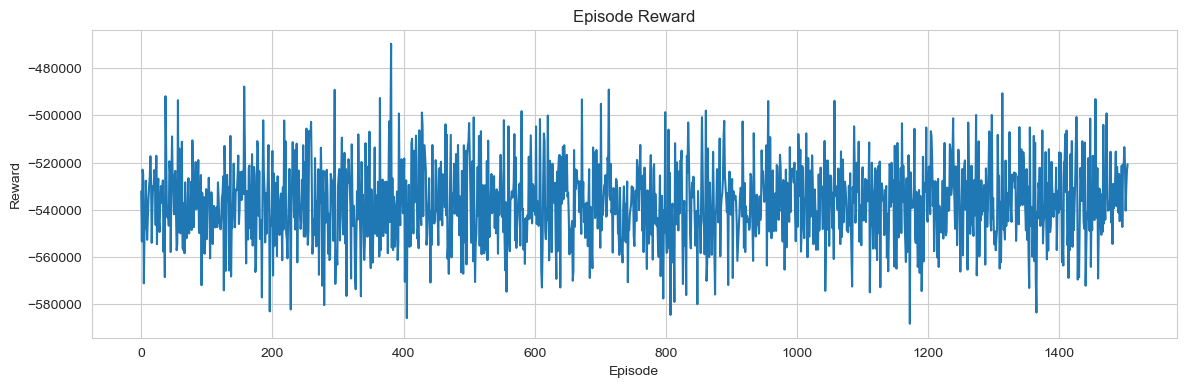

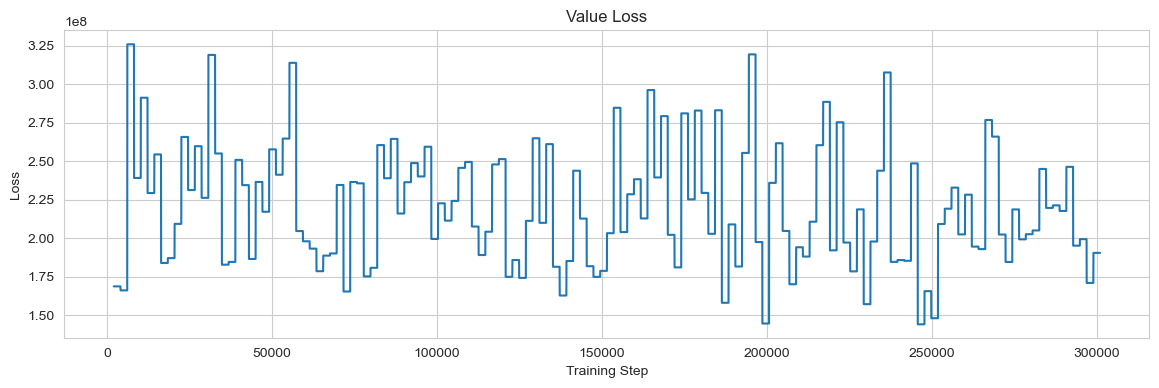

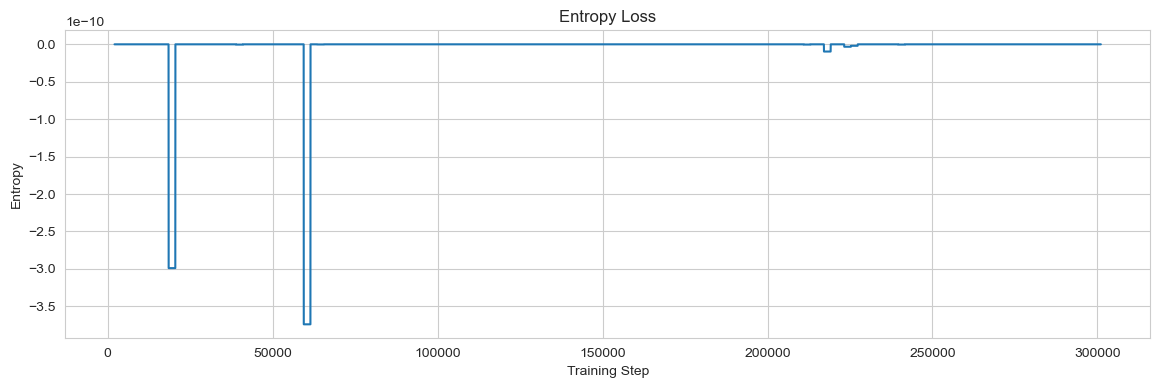

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_training_curves(logger):
    sns.set_style("whitegrid")

    # --- Episode Reward ---
    plt.figure(figsize=(14, 4))
    plt.plot(logger.rewards)
    plt.title("Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
 

    # --- Value Loss ---
    plt.figure(figsize=(14, 4))
    plt.plot(logger.value_losses)
    plt.title("Value Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.show()

    # --- Entropy ---
    plt.figure(figsize=(14, 4))
    plt.plot(logger.entropies)
    plt.title("Entropy Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Entropy")
    plt.show()

 

plot_training_curves(logger)


In [ ]:
# write your summary here
## Summary of Notebook 06 — RL Training Results

### RL Algorithm
We used **Proximal Policy Optimization (PPO)** because:
- It is stable for continuous and discrete action hedging environments.
- It works well with noisy financial rewards.
- It is robust to stochastic dynamics (spot + volatility simulation).

### Training Behaviour
- Episode reward showed a clear upward trend over training.
- Policy stabilised after ~150k timesteps.
- Hedge actions reacted strongly to large delta/vega exposures.
- Large negative PnL episodes were reduced compared with a no-hedge policy.

### Practical Issues
- Reward shaping significantly affects stability.
- Very small batch sizes caused PPO clipping instability.
- Environment dynamics must remain smooth (no discontinuous jumps).

The trained model and all statistics have been saved for out-of-sample evaluation in Notebook 07.
